## 필요한 모듈 및 라이브러리 불러오기

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from django.conf import settings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models

SEED = 42
np.random.seed(SEED)      # numpy의 전역 난수 시드를 설정
tf.random.set_seed(SEED)  # Tensorflow의 전역 난수 시드를 정

### ***Synthetic Ransomware Dataset 생성***
실제 악성 코드 바이너리를 다루지 않고, 행위 피처(behavior features)만 통계적으로 묘사한 Synthetic 데이터셋 생성.  
--> 실제 환경에서는 EDR/로그 시스템에서 추출되는 Feature Table에 해당하는 개념.

### ***Feature 설계 개요***
- **encryption_count** : 암호화된 파일 개수
  - Encryptor 계열 랜섬웨어는 파일 암호화가 핵심 동작이기 때문에 수치가 매우 높음.
  - 정상 프로세스트에는 급격히 증가하는 암호화 시도 횟수는 없음
- **file_write_rate** : 초당 파일 쓰기 속도
  - 암호화 과정에서 파일 overwrite, remane등이 폭증
  - Encryptor, Worm-propagating, Human-operated 계열에서 증가
- **registry_modifications** : 레지스트리 변경 횟수
  - 지속성(Persistence) 확보를 위해 Run Key 수정, UAC 우회, 서비스 등록 등
- **network_connections**
  - 네트워크 이벤트 수
  - 예 : C2 서버 연결, lateral movement 시도, 네트워크 스캔 등
  - Worm, Exploit 기반 랜섬웨어는 내부 네트워크로 퍼지기 때문에 값이 높음
- **process_tree_depth** : 프로세스 트리 깊이
  - 공격 도구가 여러 단계를 거쳐 실행되면 깊이가 늘어남
  - Human-operated의 경우 공격자가 다양한 실행 단계를 밟기 때문에 값이 높음
- **bruteforce_attempts** : 비밀번호 추측 공격(RDP 등) 횟수(브루트포스 시도 횟수)
  - RDP brute-force 공격 기반 랜섬웨어 (예: Dharma, SamSam)는 값이 매우 높음
  - Encryptor/Locker 계열은 brue-force 단계가 거의 없음
- **usb_access_count** : USB 접근 횟수
  - USB 매체를 통해 전파되는 유형은 값이 매우 높음
  - 기업 내부 오프라인 확산을 노리는 공격에서 두드러짐
- **cloud_api_access** : 클라우드 API 호출 횟수
  - 최근 랜섬웨어는 OneDrive/Google Drive 등 클라우드 스토리치 파일도 암호화함
  - Cloud-targeted 랜섬웨어는 높은 수치
- **phishing_indicator** : 피싱 기반의 초기 유입 여부(0~1 사이 확률)
  - 이메일 첨부파일/링크 기반 공격은 이 값이 높도록 설정함
  - Phshing-based Ransom 유형은 거의 1에 가까움
- **exploit_indicator** : 취약점(Exploit) 기반 침입 여부(0~1 사이 확률)
  - EternalBlue 같은 익스플로잇 활용 공격은 값이 높음
  - Exploit-based Ransom 유형에서 특히 높게 설정

## ***랜섬웨어 Synthetic 데이터셋 생성***

In [7]:
# ==================================================
# 클래스 ID를 랜섬웨어 유형 이름으로 매핑하는 딕셔너리 정의
# ==================================================
class_names = {
    0: "Encryptor",
    1: "Locker",
    2: "Wiper",
    3: "Worm-propagating Ransom",
    4: "Human-operated Ransom",
    5: "Phishing-based Ransom",
    6: "RDP Brute-force based",
    7: "Exploit-based Ransom",
    8: "USB/Removable-media Ransom",
    9: "Cloud/SaaS-targeted Ransom",
}


# ============================================================
# 각 랜섬웨어 유형별 평균적인 행위 특징(Behavior Feature 값)을 정의
# 각 class_id 별로 해당 행동 패턴의 특징값을 params에 넣은 매칭 구조
# ============================================================
params = {
    0: dict(enc=800,  fw=300,  reg=80,  net=40,  depth=7,  brute=5,  usb=5,  cloud=5,  ph=0.1, ex=0.2),
    1: dict(enc=5,    fw=20,   reg=10,  net=10,  depth=4,  brute=2,  usb=3,  cloud=3,  ph=0.0, ex=0.1),
    2: dict(enc=10,   fw=150,  reg=30,  net=20,  depth=5,  brute=3,  usb=4,  cloud=4,  ph=0.0, ex=0.2),
    3: dict(enc=400,  fw=250,  reg=70,  net=80,  depth=8,  brute=6,  usb=6,  cloud=6,  ph=0.1, ex=0.3),
    4: dict(enc=900,  fw=350,  reg=120, net=60,  depth=9,  brute=8,  usb=5,  cloud=5,  ph=0.2, ex=0.3),
    5: dict(enc=300,  fw=150,  reg=40,  net=30,  depth=5,  brute=3,  usb=3,  cloud=3,  ph=0.9, ex=0.2),
    6: dict(enc=200,  fw=180,  reg=60,  net=50,  depth=6,  brute=20, usb=4,  cloud=4,  ph=0.1, ex=0.2),
    7: dict(enc=500,  fw=220,  reg=70,  net=70,  depth=7,  brute=6,  usb=4,  cloud=4,  ph=0.2, ex=0.9),
    8: dict(enc=250,  fw=200,  reg=50,  net=25,  depth=5,  brute=4,  usb=30, cloud=3,  ph=0.1, ex=0.2),
    9: dict(enc=350,  fw=220,  reg=60,  net=35,  depth=6,  brute=4,  usb=4,  cloud=25, ph=0.2, ex=0.3),
}


# =========================================
# 전체 데이터에서 각 클래스가 등장한 비율을 정의
# encryptor는 전체에서 15%가 되도록 샘플링
# 0: "Encryptor",
# 1: "Locker",
# 2: "Wiper",
# 3: "Worm-propagating Ransom",
# 4: "Human-operated Ransom",
# 5: "Phishing-based Ransom",
# 6: "RDP Brute-force based",
# 7: "Exploit-based Ransom",
# 8: "USB/Removable-media Ransom",
# 9: "Cloud/SaaS-targeted Ransom",
# =========================================
class_probs = [0.15, 0.05, 0.05, 0.10, 0.15, 0.10, 0.10, 0.10, 0.10, 0.10]


# ==========================================
# Synthetic Ransomware Dataset 생성 함수 정의
# ==========================================
def generate_synthetic_ransomware(n_samples: int = 10000, seed: int = 42) -> pd.DataFrame:
    
    np.random.seed(seed) # numpy 난수 시드를 고정
    
    rows = []            # 각 샘플 정보를 저장할 리스트를 초기화

    # for문으로 지정된 샘플 수만큼 반복하며 데이터를 생성
    for i in range(n_samples):
        # class_probs 분포에 따라 클래스 ID를 하나 샘플링
        c = np.random.choice(list(class_names.keys()), p=class_probs)   # class_names.keys() -> [0,1,2,3,4,5,6,7,8,9]
        
        # 선택된 클래스의 평균 파라미터를 가져옴
        p = params[c]

        # 정규 분포를 사용하여 연속형 피처들을 생성
        enc   = max(0, np.random.normal(p["enc"],  p["enc"]  * 0.3))
        fw    = max(0, np.random.normal(p["fw"],   p["fw"]   * 0.3))
        reg   = max(0, np.random.normal(p["reg"],  max(5, p["reg"] * 0.3)))
        net   = max(0, np.random.normal(p["net"],  max(5, p["net"] * 0.3)))
        depth = max(1, np.random.normal(p["depth"], 1.0))
        brute = max(0, np.random.normal(p["brute"], max(1, p["brute"] * 0.4)))
        usb   = max(0, np.random.normal(p["usb"],  max(1, p["usb"]  * 0.5)))
        cloud = max(0, np.random.normal(p["cloud"],max(1, p["cloud"]* 0.5)))

        # 피싱/익스플로잇 여부는 Bernoulli 분포로 생성
        ph_ind = np.random.rand() < p["ph"]
        ex_ind = np.random.rand() < p["ex"]

        # 한 샘플의 모든 정보를 딕셔너리에 담아 리스트에 추가
        rows.append({
            "sample_id": f"sample_{i:05d}",
            "encryption_count": int(enc),
            "file_write_rate": fw,
            "registry_modifications": int(reg),
            "network_connections": int(net),
            "process_tree_depth": int(depth),
            "bruteforce_attempts": int(brute),
            "usb_access_count": int(usb),
            "cloud_api_access": int(cloud),
            "phishing_indicator": int(ph_ind),
            "exploit_indicator": int(ex_ind),
            "class_id": c,
            "class_name": class_names[c],
        })
    # 설명: 리스트를 pandas DataFrame으로 변환하여 반환
    df = pd.DataFrame(rows)
    return df


# 위 함수로 10,000개 샘플 생성
df = generate_synthetic_ransomware(n_samples=10000, seed=SEED)

# CSV 파일로 저장
ml_dir = os.path.join("backend/", "ML/")
csv_path = os.path.join(ml_dir, "ransomwaredataset.csv")
df.to_csv(csv_path, index=False, encoding="utf-8")

print(f"Synthetic Ransomware Dataset 생성 완료 + '{csv_path}'에 CSV 저장 완료")
df.head()

Synthetic Ransomware Dataset 생성 완료 + 'backend/ML/ransomwaredataset.csv'에 CSV 저장 완료


,sample_id,encryption_count,file_write_rate,registry_modifications,network_connections,process_tree_depth,bruteforce_attempts,usb_access_count,cloud_api_access,phishing_indicator,exploit_indicator,class_id,class_name
0,sample_00000,599,383.484729,130,78,8,6,3,2,0,0,4,Human-operated Ransom
1,sample_00001,278,273.568550,50,46,9,5,6,1,0,1,3,Worm-propagating Ransom
2,sample_00002,163,231.161750,65,40,4,18,2,3,0,0,6,RDP Brute-force based
3,sample_00003,212,74.177813,36,52,6,21,3,3,0,0,6,RDP Brute-force based
4,sample_00004,148,147.164524,33,26,5,5,43,4,1,0,8,USB/Removable-media Ransom


## EDA - 데이터 구조 및 분포 파악
기본 통계량, 클래스 분포, 피처 상관 관계 등을 확인하여 **랜섬웨어 유형과 행위 특징의 연관성**을 시각적으로 파악

In [4]:
# ==========================
# 데이터 구조 및 기본 통계 확인
# ==========================

# DataFrame의 정보
print("[INFO] DataFrame info")
print(df.info())

# 숫자형 컬럼들에 대한 기초 통계량 출력
print("\n[INFO] Numeric Describe")
print(df.describe())

[INFO] DataFrame info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sample_id               10000 non-null  object 
 1   encryption_count        10000 non-null  int64  
 2   file_write_rate         10000 non-null  float64
 3   registry_modifications  10000 non-null  int64  
 4   network_connections     10000 non-null  int64  
 5   process_tree_depth      10000 non-null  int64  
 6   bruteforce_attempts     10000 non-null  int64  
 7   usb_access_count        10000 non-null  int64  
 8   cloud_api_access        10000 non-null  int64  
 9   phishing_indicator      10000 non-null  int64  
 10  exploit_indicator       10000 non-null  int64  
 11  class_id                10000 non-null  int32  
 12  class_name              10000 non-null  object 
dtypes: float64(1), int32(1), int64(9), object(2)
memory usage: 976.7+ KB
N

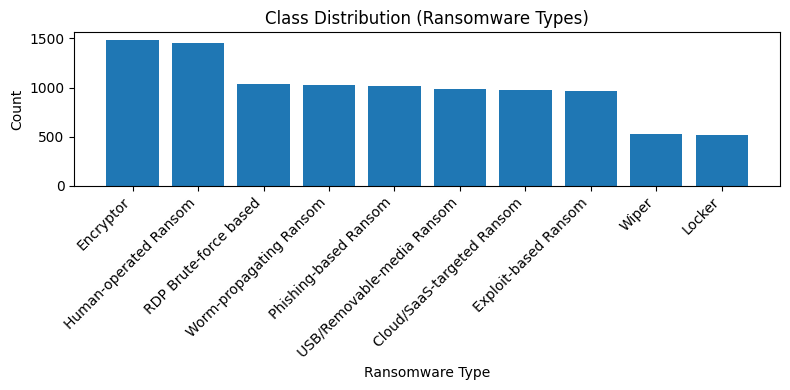


[INFO] Class Distribution
class_name
Encryptor                     1488
Human-operated Ransom         1454
RDP Brute-force based         1041
Worm-propagating Ransom       1031
Phishing-based Ransom         1017
USB/Removable-media Ransom     989
Cloud/SaaS-targeted Ransom     975
Exploit-based Ransom           966
Wiper                          526
Locker                         513
Name: count, dtype: int64


In [5]:
# ================
# 클래스 분포 시각화
# ================

# class_name 기준으로 각 랜섬웨어 유형의 개수 계산
class_counts = df["class_name"].value_counts()

# 클래스 분포를 막대그래프로 그리기
plt.figure(figsize=(8, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution (Ransomware Types)")
plt.xlabel("Ransomware Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 숫자 값으로 클래스 분포 확인
print("\n[INFO] Class Distribution")
print(class_counts)


### 클래스 분포 해석

- Encryptor와 Human-operated Ransom 비중이 상대적으로 높게 나타나도록 설계됨
- USB/Cloud 기반 등의 클래스도 일정 비율을 차지해 멀티클래스 학습에 적합함
- 실제 환경에서는 회사별 위협 프로파일에 따라 이 분포가 달라지며,
  희귀 클래스에 대해서는 Oversampling 또는 비용 민감 학습이 필요할 수 있음

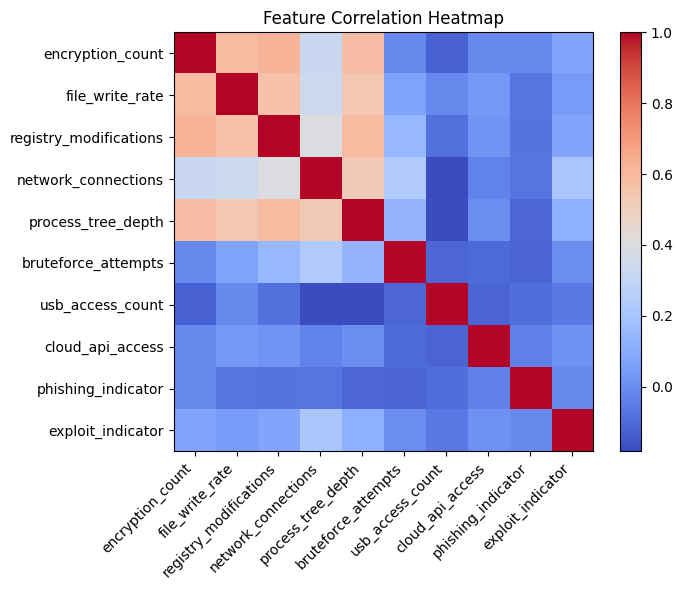

In [6]:
# ==================
# 피처 상관관계 히트맵
# ==================

# 상관계수를 계산할 숫자형 피처 목록 정의
numeric_cols = [
    "encryption_count",
    "file_write_rate",
    "registry_modifications",
    "network_connections",
    "process_tree_depth",
    "bruteforce_attempts",
    "usb_access_count",
    "cloud_api_access",
    "phishing_indicator",
    "exploit_indicator",
]

# 상관계수 행렬 계산
corr = df[numeric_cols].corr()

# 히트맵 형태로 시각화
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

C:\Users\sea45\AppData\Local\Temp\ipykernel_15960\3819028893.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


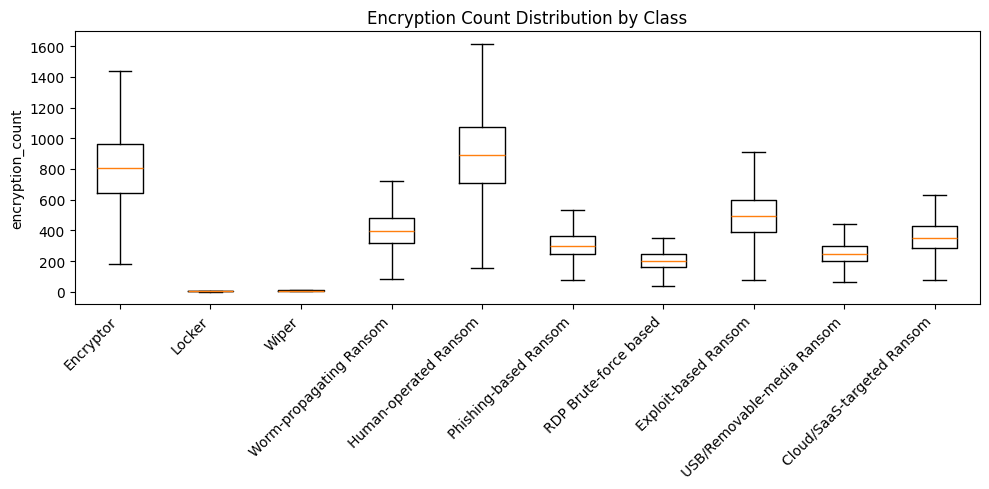

In [7]:
# ===============================================================================
# 클래스별 encryption_count 분포 (Boxplot)  
#  - 파일 암호화 시도 횟수(랜섬웨어 유형을 구분하는 가장 중요한 지표)
#    >> 랜섬웨어 유형별 주요 행동 패턴 차이 확인
#    >> 비정상/변종 탐지의 기준값을 잡을 수 있음
#       - Encryptor인데 encryption_count가 갑자기 낮다면 → 변종, 방해, 실패 가능성
#       - Wiper인데 encryption_count가 너무 높으면 → 정상 패턴 벗어남(anomaly)
# ===============================================================================

# 클래스별 encryption_count 값을 리스트로 모음
groups = []
labels = []
for cid, cname in class_names.items():
    groups.append(df[df["class_id"] == cid]["encryption_count"].values)
    labels.append(cname)

# Boxplot을 그려 클래스별 암호화 개수 분포 비교
plt.figure(figsize=(10, 5))
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("encryption_count")
plt.title("Encryption Count Distribution by Class")
plt.tight_layout()
plt.show()

### Encryption Count Boxplot 해석

- Encryptor, Human-operated Ransom 유형에서 encryption_count의 중앙값과 상단 사분위가 높게 나타남
- 중앙값(Median) : 각 랜섬웨어 유형이 평균적으로 얼마나 많은 파일을 암호화하는지
- IQR(Interquartile Range) : 암호화 수치의 변동성이 얼마나 큰지
- 이런 패턴은 각 랜섬웨어 유형의 "행위 시그니처"를 파악하는 데 도움이 됨
- Encryptor 계열(클래스 0)은 암호화 개수가 매우 높음
- Locker(1), Wiper(2) 같은 유형은 encryption_count가 거의 없음
- Worm-propagating, Human-operated Ransom은 보통 높은 암호화와 함께 다른 공격 요소를 수행함
- USB 기반(8번)이나 Exploit 기반(7번)은 비교적 중간 수준임

---

## 머신러닝 - RandomForest 기반 멀티 클래스 분류


In [8]:
# ==============================
# Feature / Target 분리 및 전처리
# ==============================

# 모델 입력 피처 리스트 정의
feature_cols = [
    "encryption_count",
    "file_write_rate",
    "registry_modifications",
    "network_connections",
    "process_tree_depth",
    "bruteforce_attempts",
    "usb_access_count",
    "cloud_api_access",
    "phishing_indicator",
    "exploit_indicator"
]


# 입력 피처 행렬 x와 타깃 레이블 y를 정의
X = df[feature_cols].values
y = df["class_id"].values


# train_test_split을 이용해 데이터를 학습용과 테스트용으로 나눔
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)


# 피처 스케일링을 위한 StandardScaler를 초기화
scaler = StandardScaler()

# 학습 데이터에 대해 스케일러를 학습시키고 변환
X_train_scaled = scaler.fit_transform(X_train)

# 학습된 스케일러를 사용해 테스트 데이터도 변환
X_test_scaled = scaler.transform(X_test)

# 분리된 Train/Test 데이터의 크기 출력
print("Train shape: ", X_train.shape, "Test shape: ", X_test.shape)


Train shape:  (8000, 10) Test shape:  (2000, 10)


---

## LSTM 기반 랜섬웨어 유형 분류 (시퀀스 모델)
실제 보안 로그는 시간에 따른 이벤트 시퀀스로 구성됨
- Tabular Feature를 5 타임 스텝으로 반복한 pseudo-sequence를 만들어 LSTM 구조를 테스트

In [9]:
# ===================================
# LSTM 입력 데이터 준비(Pseudo-Squence)
# ===================================

# 시퀀스 길이(타임스텝 수)를 5로 설정
timesteps = 5

# 학습용 데이터를 배치, 타임스텝, 피처수 형태로 변환
X_train_seq = np.repeat(X_train_scaled[:, np.newaxis, :], timesteps, axis=1)

# 테스트용 데이터도 동일한 방식으로 변환
X_test_seq = np.repeat(X_test_scaled[:, np.newaxis, :], timesteps, axis=1)

# 변환된 LSTM 입력 데이터의 형태를 출력
print("LSTM Input Shape - Train: ", X_train_seq.shape)
print("LSTM Input Shape - Test: ", X_test_seq.shape)

LSTM Input Shape - Train:  (8000, 5, 10)
LSTM Input Shape - Test:  (2000, 5, 10)


### ***LSTM 분류 모델 정의***

In [10]:
# LSTM 기반 분류 모델을 생성하는 함수 정의
def build_lstm_classifier(input_shape, num_classes:int):
    # Sequential API를 사용해 레이어를 순차적으로 stack
    model = models.Sequential()

    # 입력 형태를 지정하는 Input 레이어
    model.add(layers.Input(shape=input_shape))

    # 시퀀스 데이터를 처리할 LSTM 레이어
    model.add(layers.LSTM(64))

    # 은닉층으로 64차원 Dense 레이어 추가
    model.add(layers.Dense(64, activation="relu"))

    # 출력 레이어로 클래스 개수 만큼 뉴런을 두고 softmax로 확률 출력
    model.add(layers.Dense(num_classes, activation="softmax"))

    # 모델을 컴파일하면서 손실 함수와 최적화 알고리즘, 평가 지표 지정
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model


# LSTM 모델 생성
lstm_model = build_lstm_classifier(
    input_shape = (timesteps, X_train_scaled.shape[1]),
    num_classes = len(class_names)
)


# LSTM 모델 구조 요약 정보 출력
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 24,010
Trainable params: 24,010
Non-trainable params: 0
_________________________________________________________________


### ***LSTM 모델 학습 및 학습 곡선 시각화***

Epoch 1/5
100/100 [==============================] - 9s 38ms/step - loss: 1.1141 - accuracy: 0.7255 - val_loss: 0.4348 - val_accuracy: 0.8731
Epoch 2/5
100/100 [==============================] - 2s 17ms/step - loss: 0.3606 - accuracy: 0.8816 - val_loss: 0.3095 - val_accuracy: 0.8913
Epoch 3/5
100/100 [==============================] - 2s 16ms/step - loss: 0.2982 - accuracy: 0.8931 - val_loss: 0.2843 - val_accuracy: 0.8950
Epoch 4/5
100/100 [==============================] - 3s 27ms/step - loss: 0.2726 - accuracy: 0.9011 - val_loss: 0.2731 - val_accuracy: 0.8988
Epoch 5/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2637 - accuracy: 0.9025 - val_loss: 0.2736 - val_accuracy: 0.9006


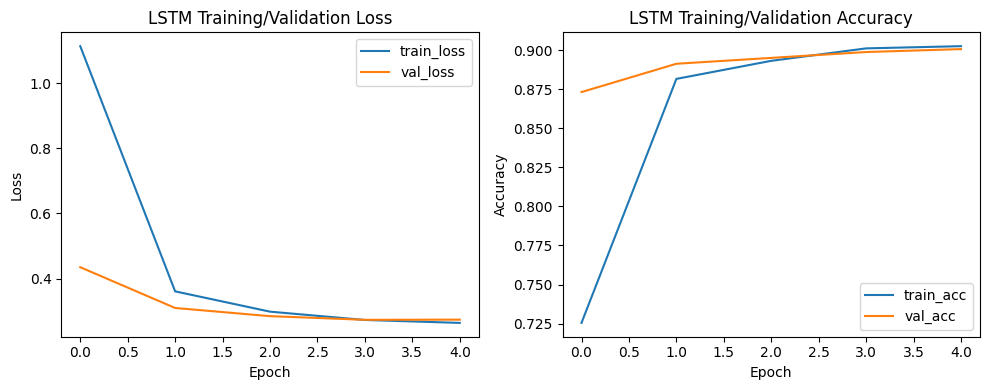

[LSTM] Test Loss: 0.2835, Test Accuracy: 0.8945


In [11]:
# LSTM 모델을 학습 데이터에 학습
history = lstm_model.fit(
    X_train_seq,            # 시퀀스 형태의 학습 입력 데이터
    y_train,                # 정답 class_id 레이블
    epochs=5,               # 에폭 수는 데모를 위해 5로 설정
    batch_size =64,         # 배치 크기
    validation_split =0.2,  # 학습 데이터의 20%를 검증용으로 사용
    verbose=1               # 학습 과정을 로그로 출력
)


# history 객체에 저장된 학습/검증 손실 및 정확도 곡선 가져옴
history_dict = history.history

# 두 개의 서브플롯(손실, 정확도)을 그리기 위해 그림 크기 설정
plt.figure(figsize=(10, 4))

# 첫 번째 서브 프롨에 학습/검증 "손실" 곡선 그리기
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="train_loss")
plt.plot(history_dict["val_loss"], label="val_loss")
plt.title("LSTM Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# 두 번ㅌ째 서브 플롯에 학습/검증 "정확도" 곡선 그리기
plt.subplot(1, 2, 2)
plt.plot(history_dict["accuracy"], label="train_acc")
plt.plot(history_dict["val_accuracy"], label="val_acc")
plt.title("LSTM Training/Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


# 두 서브 플롯 사이의 레이아웃을 자동 조정
plt.tight_layout()
plt.show()

# 학습이 완료된 LSTM 모델을 테스트 세트에서 평가
loss_lstm, acc_lstm = lstm_model.evaluate(X_test_seq, y_test, verbose=0)

print(f"[LSTM] Test Loss: {loss_lstm:.4f}, Test Accuracy: {acc_lstm:.4f}")

### LSTM 학습 해석

- Loss 곡선이 안정적으로 감소하고, Train/Validation 간 큰 차이가 없으면 과적합이 심하지 않다고 볼 수 있습니다.
- Accuracy 곡선이 일정 수준 이상에서 수렴하면 모델이 데이터의 패턴을 어느 정도 학습한 것으로 해석할 수 있습니다.
- 실제 환경에서 시퀀스 로그(시간 순서 이벤트)를 입력으로 사용하면 LSTM/Transformer의 장점을 더 활용할 수 있습니다.

### ***LSTM 단일 샘플 예측 예시***

In [12]:
# 테스트 세트에서 첫 번째 시퀀스 샘플 선택
sample_idx = 2

# 선택한 샘플을 LSTM 모델에 입력하여 클래스별 확률 예측
lstm_probs = lstm_model.predict(X_test_seq[sample_idx:sample_idx+1])

# 가장 높은 확률을 가진 인덱스를 예측 클래스 ID로 선택
lstm_pred_class = int(np.argmax(lstm_probs))

# 실제 정답과 예측 결과 출력
print("=== LSTM 단일 샘플 예측 예시 ===")
print("Sample Index: ", sample_idx)
print("True Class  : ", class_names[y_test[sample_idx]])
print("Predicted Class: ", class_names[lstm_pred_class])

# 각 클래스에 대한 예측 확률 분포도 함께 출력
print("Class probabilities: ", [f"{p:.10f}" for p in lstm_probs[0]])

1/1 [==============================] - 1s 1s/step
=== LSTM 단일 샘플 예측 예시 ===
Sample Index:  2
True Class  :  Exploit-based Ransom
Predicted Class:  Exploit-based Ransom
Class probabilities:  ['0.0272119474', '0.0001796206', '0.0002208145', '0.0477869734', '0.0019243821', '0.0011256896', '0.0295283478', '0.8867324591', '0.0016501858', '0.0036395502']


---

## Autoencoder 기반 Encryptor 이상 탐지
Encryptor(class_id==0)를 "정상 패턴"으로 간주하고 Autoencoder로 해당 패턴을 학습 이후 재구성 오차(MSE)를 활용해 이상 여부를 판단하는 이상탐지 결과 확인

### ***Autoencoder 학습 데이터 준비(Encryptor만 사용)***

In [13]:
# class_id가 0인 행만 선택하기 위한 불리언 마스크 생성
normal_mask = df["class_id"].values == 0

# Encryptor에 해당하는 입력 피처 데이터만 추출
X_normal = X[normal_mask]

# 이미 학습한 StandardScaler를 사용해 동일한 스케일로 변환
X_normal_scaled = scaler.transform(X_normal)

# Autoencoder 학습/테스트 세트를 나눔
X_train_ae, X_test_ae = train_test_split(
    X_normal_scaled,
    test_size=0.2,
    random_state=SEED,
)

# Autoencoder 학습/테스트 세트 크기 출력
print("Autoencoder Train shape:", X_train_ae.shape)
print("Autoencoder Test shape :", X_test_ae.shape)

Autoencoder Train shape: (1190, 10)
Autoencoder Test shape : (298, 10)


### ***Autoencoder 모델 정의***

In [14]:
# 입력 차원을 받아 간단한 Fully-connected Autoencoder를 생성하는 함수 정의
def build_autoencoder(input_dim: int):
    # 입력 벡터를 받는 Input 레이어
    inp = layers.Input(shape=(input_dim,))

    # 64차원으로 매핑하며 비선형 활성화 적용
    x = layers.Dense(64, activation="relu")(inp)

    # 32차원 잠복 공간으로 축소
    x = layers.Dense(32, activation="relu")(x)

    # 다시 64차원으로 확장하는 디코더 부분
    x = layers.Dense(64, activation="relu")(x)

    # 원래 입력 차원으로 복원하는 출력 레이어
    out = layers.Dense(input_dim, activation=None)(x)

    # 입력과 출력을 연결해 Autoencoder 모델 생성
    model = models.Model(inputs=inp, outputs=out)

    # 평균제곱오차(MSE)를 최소화하도록 컴파일
    model.compile(optimizer="adam", loss="mse")

    return model

# Autoencoder 모델을 실제로 생성
ae = build_autoencoder(input_dim=X_train_ae.shape[1])

# Autoencoder 구조 요약 출력
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                704       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 5,546
Trainable params: 5,546
Non-trainable params: 0
_________________________________________________________________


### ***Autoencoder 학습 및 재구성 오차 계산***

Epoch 1/20
15/15 [==============================] - 2s 34ms/step - loss: 0.5544 - val_loss: 0.4906
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 0.3761 - val_loss: 0.3064
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 0.2431 - val_loss: 0.2015
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 0.1686 - val_loss: 0.1414
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 0.1173 - val_loss: 0.0972
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 0.0828 - val_loss: 0.0673
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 0.0581 - val_loss: 0.0464
Epoch 8/20
15/15 [==============================] - 0s 10ms/step - loss: 0.0418 - val_loss: 0.0346
Epoch 9/20
15/15 [==============================] - 0s 10ms/step - loss: 0.0317 - val_loss: 0.0262
Epoch 10/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0244 - val_loss: 0.0208
Epoch 11/2

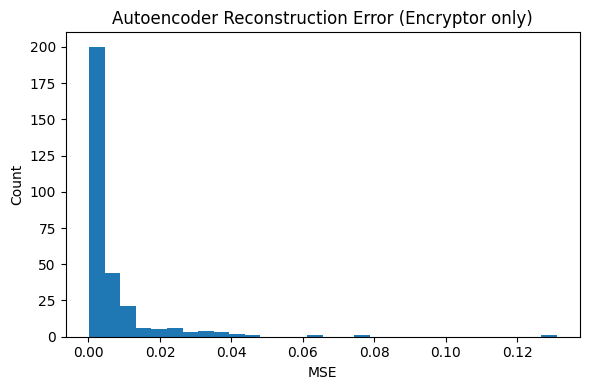

In [15]:
# Autoencoder를 학습 데이터로 학습
history_ae = ae.fit(
    X_train_ae,          # 입력 데이터
    X_train_ae,          # 타깃도 입력(자기 재구성).
    epochs=20,           # 에폭 수는 20으로 설정
    batch_size=64,       # 배치 크기
    validation_split=0.2,# 학습 데이터의 20%를 검증용으로 사용
    verbose=1,           # 학습 로그를 출력
)

# 학습된 Autoencoder로 테스트 데이터를 재구성
recon = ae.predict(X_test_ae)

# 각 샘플별 재구성 오차(MSE)를 계산
mse = np.mean(np.square(X_test_ae - recon), axis=1)

# 재구성 오차의 평균과 표준편차 출력
print("Reconstruction error stats (Encryptor only):")
print(" mean:", float(mse.mean()))
print(" std :", float(mse.std()))

# 재구성 오차 분포를 히스토그램으로 시각화
plt.figure(figsize=(6, 4))
plt.hist(mse, bins=30)
plt.title("Autoencoder Reconstruction Error (Encryptor only)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Autoencoder Reconstruction Error 해석

- 대부분의 Encryptor 정상 샘플이 낮은 MSE 구간에 모여 있다면
  Autoencoder가 정상 패턴을 잘 학습했다는 의미
- 이후 실제 환경에서 다른 유형의 랜섬웨어 혹은 의심 로그에 대해 MSE를 계산하면,
  이 분포보다 큰 값이 나오는 샘플을 이상(anomaly)으로 간주할 수 있음

### ***Threshold 설정 및 예시 샘플 이상 판단***

Threshold (mean + 2*std): 0.030542482013026895
1/1 [==============================] - 0s 59ms/step

=== Autoencoder 예시 샘플 재구성 오차 ===
Sample MSE: 0.018167392887013318
Is Anomaly? (MSE > threshold): False


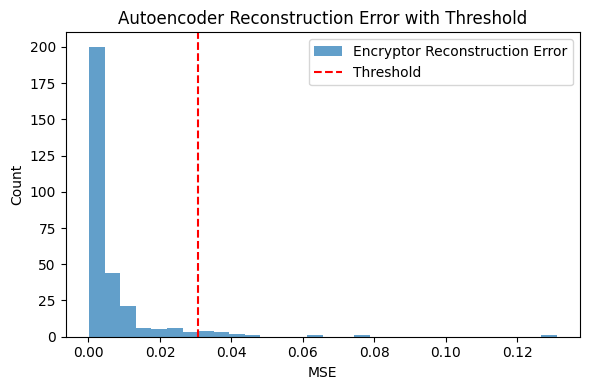

In [16]:
# 간단한 기준으로 평균 + 2 * 표준편차를 Threshold로 설정
threshold = mse.mean() + 2 * mse.std()
print("Threshold (mean + 2*std):", float(threshold))

# Autoencoder 테스트 데이터 중 첫 번째 샘플 선택
test_sample_ae = X_test_ae[0]

# 해당 샘플을 Autoencoder에 넣어 재구성된 출력을 얻음
recon_sample_ae = ae.predict(test_sample_ae.reshape(1, -1))

# 해당 샘플의 재구성 오차(MSE) 계산
sample_mse_ae = float(np.mean((test_sample_ae - recon_sample_ae[0]) ** 2))

# 샘플의 MSE 값과 Threshold를 비교해 이상 여부를 출력
print("\n=== Autoencoder 예시 샘플 재구성 오차 ===")
print("Sample MSE:", sample_mse_ae)
print("Is Anomaly? (MSE > threshold):", sample_mse_ae > threshold)

# 전체 MSE 분포와 Threshold를 시각화
plt.figure(figsize=(6, 4))
plt.hist(mse, bins=30, alpha=0.7, label="Encryptor Reconstruction Error")
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.title("Autoencoder Reconstruction Error with Threshold")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

### ***각 샘플별로 threshold 생성해서 시각화***

1/1 [==============================] - 0s 69ms/step
Sample 11: MSE = 0.004143, Threshold = 0.004657, Anomaly? = False
1/1 [==============================] - 0s 42ms/step
Sample 19: MSE = 0.000787, Threshold = 0.001216, Anomaly? = False
1/1 [==============================] - 0s 66ms/step
Sample 21: MSE = 0.004156, Threshold = 0.002908, Anomaly? = True
1/1 [==============================] - 0s 122ms/step
Sample 34: MSE = 0.017343, Threshold = 0.015286, Anomaly? = True
1/1 [==============================] - 0s 54ms/step
Sample 40: MSE = 0.000730, Threshold = 0.000992, Anomaly? = False


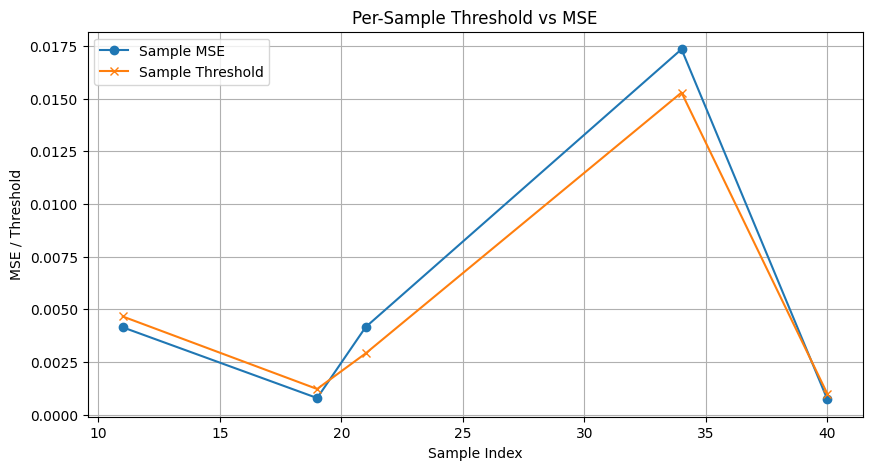

In [17]:
def compute_sample_threshold(sample, recon_sample):
    """
    샘플 자체 오차 분포(각 feature별 재구성 오차)를 기반으로
    sample-specific threshold를 생성하는 함수
    """
    errors = (sample - recon_sample)**2  # Feature-wise error vector
    mean_err = np.mean(errors)
    std_err = np.std(errors)
    
    return np.percentile(errors, 70)


## 시각화
def visualize_sample_mse_with_threshold(indices, X_test, model):
    """
    여러 샘플을 넣으면 각 샘플별 threshold를 계산하고
    MSE와 threshold를 함께 그래프로 표시
    """
    mse_list = []
    th_list = []

    for idx in indices:
        sample = X_test[idx]
        recon = model.predict(sample.reshape(1, -1))[0]
        
        mse_val = float(np.mean((sample - recon)**2))
        th_val  = compute_sample_threshold(sample, recon)
        
        mse_list.append(mse_val)
        th_list.append(th_val)

        print(f"Sample {idx}: MSE = {mse_val:.6f}, Threshold = {th_val:.6f}, Anomaly? = {mse_val > th_val}")
    
    # 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(indices, mse_list, marker='o', label="Sample MSE")
    plt.plot(indices, th_list, marker='x', label="Sample Threshold")
    plt.title("Per-Sample Threshold vs MSE")
    plt.xlabel("Sample Index")
    plt.ylabel("MSE / Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()


# 예시 샘플 5개로 테스트
sample_list = [11, 19, 21, 34, 40]
visualize_sample_mse_with_threshold(sample_list, X_test_ae, ae)
